In [17]:
import requests
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import psycopg2

In [18]:
url = f"https://www.imdb.com/title/tt0112401/"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}
response = requests.get(url,headers=headers)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

In [19]:
def get_real_scenarist_stars(soup):
    lis = soup.find_all("ul",attrs={"class":"ipc-metadata-list ipc-metadata-list--dividers-all title-pc-list ipc-metadata-list--baseAlt"})[0]
    meta_data = list()
    for nb,li in enumerate(lis):
        data = list(li.strings)
        meta_data.append(data[0:])
    realisateur,scenarist,stars = list(), list(), list()
    for data in meta_data:
        if data[0].startswith("Director"):
                realisateur = data[1:]
        if data[0].startswith("Writer"):
                scenarist = data[1:]
        if data[0].startswith("Star"):
                stars = data[1:] 
    return realisateur,scenarist,stars

In [20]:
get_real_scenarist_stars(soup)

(['Richard Donner'],
 ['Lilly Wachowski', 'Lana Wachowski', 'Brian Helgeland'],
 ['Sylvester Stallone', 'Antonio Banderas', 'Julianne Moore'])

In [21]:
def get_summary(soup):
   summary = soup.find_all("span",attrs={"class":"sc-466bb6c-1 dWufeH"})[0]

   if list(summary) :
      summary=list(summary)[0]
   else:
      summary = ''
   return summary


In [22]:
get_summary(soup)

"Professional hit-man Robert Rath wants to fulfill a few more contracts before retiring but unscrupulous ambitious newcomer hit-man Miguel Bain keeps killing Rath's targets."

In [23]:
def get_public_access_duration(soup):
    items = list()    
    uls = soup.find_all("ul",attrs={"class":"ipc-inline-list ipc-inline-list--show-dividers sc-d8941411-2 cdJsTz baseAlt"})
    for ul in uls:
        for lis in ul.find_all('li'):
            for li in lis:
                for text in li.strings:
                    items.append(text)
    return items[-2:]

In [24]:
get_public_access_duration(soup)

['Tous publics', '2h 13m']

In [25]:
def get_affiche_url (soup):
    div = soup.find_all("div",attrs={"class":"ipc-poster ipc-poster--baseAlt ipc-poster--dynamic-width ipc-sub-grid-item ipc-sub-grid-item--span-2"})
    try:
        imge_url = "https://www.imdb.com/" + div[0].find_all("a")[0]['href']
        response = requests.get(imge_url,headers=headers)

        if response.status_code == 200:
            soup_image = BeautifulSoup(response.content, 'html.parser')
        return soup_image.find_all("img",srcset=True)[0]["srcset"].split(",")[-2].split()[0]
    except IndexError:
        return ''


In [26]:
get_affiche_url (soup)

'https://m.media-amazon.com/images/M/MV5BYzk4MjQ5NDMtNmI5Zi00YmU3LWFhMzAtMjJkY2IyZjNmOGYyXkEyXkFqcGdeQXVyMTEyODk3NTgz._V1_FMjpg_UX600_.jpg'

In [27]:


def scrape_imdb(imdb_id):
    url = f"https://www.imdb.com/title/tt{imdb_id}/"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    response = requests.get(url,headers=headers)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        # Exemple pour extraire le titre du film
        title_tag = soup.find('h1')
        summary = get_summary(soup)
        title = title_tag.text.strip()
        try:
            pub_acc,duration =  get_public_access_duration(soup)
        except ValueError:
            print (get_public_access_duration(soup))
            pub_acc,duration = '',''
        
        affiche_url = get_affiche_url(soup)
        realisateur,scenarist,stars = get_real_scenarist_stars(soup)
        
        return {
            "titre": title,
            "summary": summary,
            "certificat": pub_acc,
            "duration": duration,
            "poster": affiche_url,
            "directors": '|'.join(realisateur),
            "writers": '|'.join(scenarist),
            "stars": '|'.join(stars)


        }
    else:
        raise ValueError

# Exemple d'utilisation
imdb_id = "0058536" 
resultat = scrape_imdb(imdb_id)
print(resultat)


{'titre': 'Rudolph, le petit renne au nez rouge', 'summary': "A young reindeer Rudolph lives at the North Pole. His father is one of Santa's reindeer and it is expected that Rudolph will eventually be one too. However, he has a feature which is a setback and causes him to be ostracized: his red nose.", 'certificat': 'TV-G', 'duration': '47m', 'poster': 'https://m.media-amazon.com/images/M/MV5BNGE4YjU4ODMtMGViMS00YmM1LWE4ZGUtZDQ4NjllNzc3NTQ0XkEyXkFqcGdeQXVyMTA0MDM3NDg4._V1_FMjpg_UX592_.jpg', 'directors': 'Larry Roemer', 'writers': 'Romeo Muller|Robert May|Johnny Marks', 'stars': 'Billie Mae Richards|Burl Ives|Larry D. Mann'}


In [28]:
db_params = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'recommendation_films_oct_23_MLOPS',
    'host': 'reco-films-db.ck2uuvj8tg5b.eu-west-3.rds.amazonaws.com',
    'port': '5432'
}

In [29]:
#     creation = """CREATE TABLE IMDB_DATA (
#     movieid INTEGER PRIMARY KEY,
#     titre VARCHAR(255),
#     summary TEXT,
#     certificat VARCHAR(50),
#     duration VARCHAR(10),
#     poster TEXT,
#     directors VARCHAR(500),
#     writers VARCHAR(500),
#     stars VARCHAR(500),
#     FOREIGN KEY(movieid) REFERENCES Movie(movieid)
# );
#     """

# conn = psycopg2.connect(**db_params)
# cursor = conn.cursor()
# cursor.execute(creation)
# conn.commit()
# cursor.close()

In [30]:
def get_sql(film_data):
    columns = ', '.join(film_data.keys())
    placeholders = ', '.join(['%s'] * len(film_data))
    sql = "INSERT INTO imdb_data ({}) VALUES ({});".format(columns, placeholders)
    return sql

In [31]:

conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

query = """
SELECT m.imdbid,m.movieid
FROM movie m
inner join movie tr on tr.movieid = m.movieid
left outer join  imdb_data id on id.movieid = tr.movieid
where id.movieid is null
order by random()
"""
cursor.execute(query)
imdbid = cursor.fetchall()
list_imdb = list(imdbid)
list_imdb =  list(map(lambda x: (f"{x[0]:07}",x[1]),list_imdb))
conn.close()

In [32]:
import PIL,urllib
import numpy as np


{'titre': 'Urvakannere heranum en lernerits',
 'summary': '',
 'certificat': '1955',
 'duration': '1h 36m',
 'poster': 'https://m.media-amazon.com/images/M/MV5BM2NkM2Q0YzQtZGJhYS00NTZhLTk2ZTgtZTYwYzllOTY5YzlhXkEyXkFqcGdeQXVyMTk0NjM1ODQ@._V1_FMjpg_UX371_.jpg',
 'directors': 'Erazm Karamyan|Stepan Kevorkov',
 'writers': 'Erazm Karamyan|Grigoriy Koltunov',
 'stars': 'Sos Sosyan|Violetta Yutujyan|Artyom Karapetyan'}

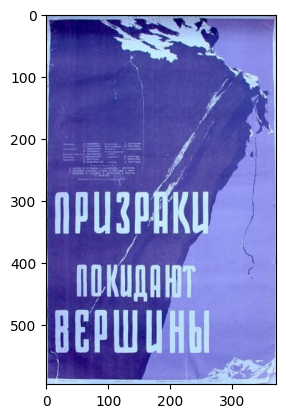

In [33]:
import matplotlib.pyplot as plt
data = scrape_imdb("0193433")
img = np.array(PIL.Image.open(urllib.request.urlopen(data['poster'])))
plt.imshow(img);
data

In [34]:
all_movie_data=[]
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()
nb_ligne = 0
for imdb,movieid in tqdm(list_imdb):
    try:
        movie_data = scrape_imdb(imdb)
        movie_data['movieid'] = movieid
        sql = get_sql(movie_data)
        cursor.execute(sql, list(movie_data.values()))
        conn.commit()
    except Exception:
      print(imdb)


  0%|          | 0/7 [00:00<?, ?it/s]

0118114
['1903']
0000456
0334960
1347439
